<a href="https://colab.research.google.com/github/MammadovN/Machine_Learning/blob/main/projects/03_deep_learning/sequence_modelling/time_series_prediction/Temp_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, io, zipfile, requests, math, random
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED    = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

In [2]:
URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"  # :contentReference[oaicite:0]{index=0}

csv = requests.get(URL, timeout=30).content
df = pd.read_csv(io.BytesIO(csv), parse_dates=["Date"])
df.rename(columns={"Temp": "temp_c"}, inplace=True)
df.sort_values("Date", inplace=True)


In [3]:
look_back = 30
val_ratio = test_ratio = 0.15
n = len(df)
test_len = int(n * test_ratio); val_len = int(n * val_ratio)
train_df = df.iloc[: -val_len - test_len]
val_df   = df.iloc[-val_len - test_len : -test_len]
test_df  = df.iloc[-test_len:]

scaler = StandardScaler().fit(train_df.temp_c.values.reshape(-1,1))
def norm(a):  return scaler.transform(a.reshape(-1,1)).squeeze()

def windows(a, lb):
    X, y = [], []
    for i in range(len(a) - lb):
        X.append(a[i:i+lb]); y.append(a[i+lb])
    return np.array(X), np.array(y)

Xtr, ytr = windows(norm(train_df.temp_c.values), look_back)
Xva, yva = windows(norm(val_df.temp_c.values), look_back)
batch = 256
def loader(X, y, shuffle=True):
    ds = TensorDataset(torch.tensor(X).float().unsqueeze(-1),
                       torch.tensor(y).float().unsqueeze(-1))
    return DataLoader(ds, batch_size=batch, shuffle=shuffle)
train_loader = loader(Xtr, ytr, True)
val_loader   = loader(Xva, yva, False)


In [4]:
class LSTM(nn.Module):
    def __init__(self, hid=128, layers=2, drop=0.1):
        super().__init__()
        self.lstm = nn.LSTM(1, hid, layers, dropout=drop, batch_first=True)
        self.fc   = nn.Linear(hid, 1)
    def forward(self, x):
        out,_ = self.lstm(x)
        return self.fc(out[:,-1])

model = LSTM().to(DEVICE)
optim  = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [5]:
epochs = 50
best = math.inf
for ep in range(1, epochs+1):
    model.train()
    for xb,yb in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}", leave=False):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optim.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        optim.step()
    # validation
    model.eval(); val_loss = 0
    with torch.no_grad():
        for xb,yb in val_loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            val_loss += loss_fn(model(xb), yb).item() * len(xb)
    val_rmse = (val_loss/len(val_loader.dataset))**0.5
    print(f"  val_RMSE: {val_rmse:.3f} °C")
    if val_rmse < best:
        best = val_rmse
        torch.save({"model": model.state_dict(), "scaler": scaler}, "best.pth")

  val_RMSE: 0.760 °C


  val_RMSE: 0.692 °C


  val_RMSE: 0.658 °C


  val_RMSE: 0.655 °C


  val_RMSE: 0.648 °C


  val_RMSE: 0.645 °C


  val_RMSE: 0.640 °C


  val_RMSE: 0.633 °C


  val_RMSE: 0.627 °C


  val_RMSE: 0.618 °C


  val_RMSE: 0.604 °C


  val_RMSE: 0.586 °C


  val_RMSE: 0.574 °C


  val_RMSE: 0.572 °C


  val_RMSE: 0.568 °C


  val_RMSE: 0.566 °C


  val_RMSE: 0.571 °C


  val_RMSE: 0.566 °C


  val_RMSE: 0.570 °C


  val_RMSE: 0.564 °C


  val_RMSE: 0.564 °C


  val_RMSE: 0.564 °C


  val_RMSE: 0.562 °C


  val_RMSE: 0.563 °C


  val_RMSE: 0.564 °C


  val_RMSE: 0.563 °C


  val_RMSE: 0.565 °C


  val_RMSE: 0.564 °C


  val_RMSE: 0.567 °C


  val_RMSE: 0.562 °C


  val_RMSE: 0.563 °C


  val_RMSE: 0.561 °C


  val_RMSE: 0.562 °C


  val_RMSE: 0.561 °C


  val_RMSE: 0.561 °C


  val_RMSE: 0.564 °C


  val_RMSE: 0.564 °C


  val_RMSE: 0.559 °C


  val_RMSE: 0.560 °C


  val_RMSE: 0.560 °C


  val_RMSE: 0.560 °C


  val_RMSE: 0.560 °C


  val_RMSE: 0.560 °C


  val_RMSE: 0.563 °C


  val_RMSE: 0.559 °C


  val_RMSE: 0.560 °C


  val_RMSE: 0.560 °C


  val_RMSE: 0.560 °C


  val_RMSE: 0.563 °C


  val_RMSE: 0.560 °C


In [7]:
def predict_future(steps=14, ckpt_path="best.pth"):
    chk = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)

    model.load_state_dict(chk["model"])
    model.eval()
    scl = chk["scaler"]

    series = df.temp_c.values
    norm_series = norm(series)
    window = norm_series[-look_back:].tolist()

    preds_norm = []
    with torch.no_grad():
        for _ in range(steps):
            inp = (
                torch.tensor(window[-look_back:], dtype=torch.float32, device=DEVICE)
                .unsqueeze(0)          # (1, look_back)
                .unsqueeze(-1)         # (1, look_back, 1)
            )
            next_norm = model(inp).cpu().item()
            preds_norm.append(next_norm)
            window.append(next_norm)

    return scl.inverse_transform(np.array(preds_norm).reshape(-1, 1)).squeeze()


future = predict_future(14)
dates  = pd.date_range(df.Date.iloc[-1] + pd.Timedelta(days=1), periods=14)


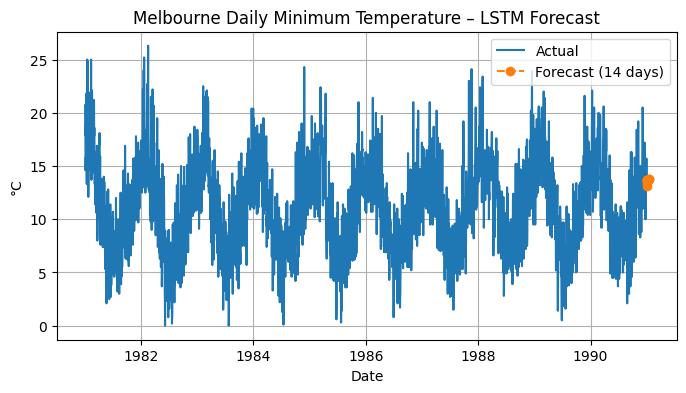


Forecast:
1991-01-01 → 13.08 °C
1991-01-02 → 13.45 °C
1991-01-03 → 13.66 °C
1991-01-04 → 13.73 °C
1991-01-05 → 13.73 °C
1991-01-06 → 13.71 °C
1991-01-07 → 13.70 °C
1991-01-08 → 13.69 °C
1991-01-09 → 13.69 °C
1991-01-10 → 13.70 °C
1991-01-11 → 13.72 °C
1991-01-12 → 13.73 °C
1991-01-13 → 13.74 °C
1991-01-14 → 13.75 °C


In [9]:
plt.plot(df.Date, df.temp_c, label="Actual")
plt.plot(dates, future, marker="o", linestyle="--", label="Forecast (14 days)")
plt.title("Melbourne Daily Minimum Temperature – LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("°C")
plt.legend()
plt.grid(True)
plt.show()

print("\nForecast:")
for d, t in zip(dates, future):
    print(f"{d.date()} → {t:.2f} °C")
